In [8]:
using Gen, Plots, Images, Colors, Serialization

In [9]:
# Global vars
IMG_SIZE = 50;

## Rendering of a scene

In [985]:
# Drawing utilities

# colors
BLANK = [1.0, 1.0, 1.0]
color_map = Dict("red" => [1.0, 0.0, 0.0], "yellow" => [1.0, 1.0, 0.0], "green" => [0.0, 1.0, 0.0])

# shapes
function draw_square!(img, center, size, color)
    overlap = false
    x, y = center
    half_size = size ÷ 2
    for dx in -half_size:half_size, dy in -half_size:half_size
        nx, ny = x + dx, y + dy
        if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
            if img[ny, nx] != BLANK
                overlap = true
            end
            img[ny, nx] = color
        end
    end
    return overlap
end

# Function to draw a circle
function draw_circle!(img, center, radius, color)
    overlap = false
    x, y = center
    for dx in -radius:radius, dy in -radius:radius
        if dx^2 + dy^2 <= radius^2
            nx, ny = x + dx, y + dy
            if 1 <= nx <= IMG_SIZE && 1 <= ny <= IMG_SIZE
                if img[ny, nx] != BLANK
                    overlap = true
                end
                img[ny, nx] = color
            end
        end
    end
    return overlap
end

shape_map = Dict("square" => draw_square!, "circle" => draw_circle!, "star" => draw_square!)

Dict{String, Function} with 3 entries:
  "circle" => draw_circle!
  "star"   => draw_square!
  "square" => draw_square!

In [169]:
function to_display_img(img_matrix)
    return [RGB(img_matrix[i, j]...) for i in 1:IMG_SIZE, j in 1:IMG_SIZE]
end

function render(objects, show_img=false, return_does_overlap=false)
    overlap = false
    img = fill([1.0,1.0,1.0], IMG_SIZE, IMG_SIZE)
    for (shape, color, center) in objects
        if shape_map[shape](img, center, 10, color_map[color])
            overlap = true
        end
    end
    if show_img
        display(to_display_img(img))
    end
    if return_does_overlap
        return img, overlap
    end
    return img
end

function render_trace(trace, show_img=false)
    objects = get_retval(trace)
    return render(objects, show_img)
    end

render_trace (generic function with 2 methods)

## Generative model for a scene

In [279]:
# See if should be static compiled for inference efficiency
@gen function scene()
    # Defining how many objects are in the scene
    n_objects ~ poisson(2)
    n_objects += 1 # Making sure at least 1 object

    shape_universe = ["square", "circle"]
    color_universe = ["red", "yellow", "green"]

    # Should probably make this a passed in param
    
    objects = []
    for i = 1:n_objects

        shape_idx = {(:shape, i)} ~ uniform_discrete(1,2)
        shape = shape_universe[shape_idx]

        color_idx = {(:color, i)} ~ uniform_discrete(1,3)
        color = color_universe[color_idx]

        x = {(:x, i)} ~ uniform_discrete(1, IMG_SIZE)
        y = {(:y, i)} ~ uniform_discrete(1, IMG_SIZE)
        
        push!(objects, (shape, color, (x, y)))
    end
    
    return objects
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##scene#1312", Bool[], false)

In [13]:
# Generative for scoring
@gen function render_model()
    latents ~ scene()
    x = render(latents)
    obs ~ obs_mixture(x)
    return nothing
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_model#293", Bool[], false)

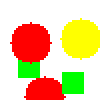

In [15]:
# Example usage
render_trace(Gen.simulate(scene, ()), true);

## Scoring sampled scenes

In [16]:
# Image observation distribution
struct ObservationMixture <: Distribution{Matrix{Vector{Float64}}} end

function Gen.random(::ObservationMixture, X::Matrix{Vector{Float64}})
    # Throw an error since just a scoring fn
    return X
end

function Gen.logpdf(::ObservationMixture,
        Y::Matrix{Vector{Float64}},
        X::Matrix{Vector{Float64}})

    blank = fill([1.0,1.0,1.0], size(X))
    input_non_background_mask = .!(X .== blank)
    obs_non_background_mask = .!(Y .== blank)

    obs_non_background = Y[input_non_background_mask]
    input_non_background = X[input_non_background_mask]

    # Use IOU (intersection over union) as score
    intersection = sum(obs_non_background .== input_non_background)
    union = sum(obs_non_background_mask .| input_non_background_mask)
    return log(intersection) - log(union)
end

function obs_score(obs, gen)
    return logpdf(ObservationMixture(), obs, gen)
end

(o::ObservationMixture)(arg) = Gen.random(o, arg)

In [17]:
obs_mixture = ObservationMixture()
foo = render(scene())
foo2 = render(scene())
_ = obs_mixture(foo)
print("Sanity checking score fn: ", exp(logpdf(obs_mixture, foo,  foo)))

Sanity checking score fn: 1.0

## Inference procedure

In [442]:
# Inference display utils
function render_samples(traces, log_weights)
    # normalized_log_weights = log_weights .- logsumexp(log_weights)
    # sample_weights = exp.(normalized_log_weights)
    # cum_sampled_scene = render(traces[1][:latents]) * sample_weights[1]
    # for i=2:length(traces)
    #     sampled_scene = render(traces[i][:latents]) * sample_weights[i]
    #     cum_sampled_scene += sampled_scene
    # end
    # return cum_sampled_scene
    
    # normalized_log_weights = log_weights .- logsumexp(log_weights)
    # sample_weights = exp.(normalized_log_weights)
    cum_sampled_scene = render(traces[1][:latents]) * (1 / length(traces))
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * (1 / length(traces))
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

render_samples (generic function with 1 method)

In [19]:
# MAP estimate of paramters (ML since uniform)
function get_ml_trace(traces, log_weights)
    log_weights = log_weights .- logsumexp(log_weights)
    weight_sort_perm = sortperm(log_weights, rev=true)
    sorted_weights = log_weights[weight_sort_perm]
    sorted_traces = traces[weight_sort_perm]
    return sorted_traces[1], sorted_weights[1]
end

get_ml_trace (generic function with 1 method)

In [983]:
obs_trace_1, _ = generate(scene, (), Gen.choicemap())
obs = render_trace(obs_trace_1);
to_display_img(obs)

LoadError: MethodError: objects of type Int64 are not callable
Maybe you forgot to use an operator such as [36m*, ^, %, / etc. [39m?

In [438]:
# Example inference procedure
function do_importance_sample(model, constraints, num_iter)
    (traces, weights, _) = Gen.importance_sampling(model, (), constraints, num_iter);
    return traces, weights
end;

In [439]:
constraints = Gen.choicemap()
constraints[:obs] = obs
traces, weights = do_importance_sample(render_model, constraints, 100000);

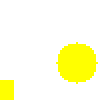

In [440]:
to_display_img(obs)

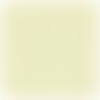

In [443]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.6151260504201677


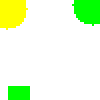

In [369]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

In [371]:
get_score(best_trace)

-30.64019733183736

### Experimenting w/ constraints

In [31]:
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

traces, weights = do_importance_sample(render_model, constraints, 100000);

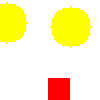

In [32]:
to_display_img(obs)

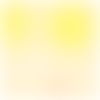

In [33]:
to_display_img(render_samples(traces, weights))

P(obs|latent*) 0.7741514360313321


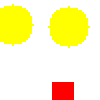

In [34]:
best_trace, best_weight = get_ml_trace(traces, weights)
println("P(obs|latent*) ", exp(obs_score(obs, render(best_trace[:latents]))))
to_display_img(render_samples([best_trace,], [best_weight,]))

## MCMC

In [35]:
function get_unconstrained_vars(vars, constraints)
    valid_vars = []
    for var in vars
        if !Gen.has_value(constraints, var)
            push!(valid_vars, var)
        end
    end
    return valid_vars
end

get_unconstrained_vars (generic function with 1 method)

In [36]:
# Just to get started, doing unconditional resimulation
function block_resimulation_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Block to change the position
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, select(
                :latents => (:x, i),
                :latents => (:y, i),))
    end
    
    # Return the updated trace
    tr
end;


In [37]:
# Just to get started, doing unconditional resimulation
MAX_DRIFT = 2
@gen function position_proposal(current_trace, i)
    cur_x = current_trace[:latents => (:x, i)]
    cur_y = current_trace[:latents => (:y, i)]
    
    new_x_min = max(cur_x-MAX_DRIFT, 1)
    new_x_max = min(cur_x+MAX_DRIFT, IMG_SIZE)
    new_y_min = max(cur_y-MAX_DRIFT, 1)
    new_y_max = min(cur_y+MAX_DRIFT, IMG_SIZE)
    
    x = {:latents => (:x, i)} ~ uniform_discrete(new_x_min, new_x_max)
    y = {:latents => (:y, i)} ~ uniform_discrete(new_y_min, new_y_max)
end;

function block_drift_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Update block positions
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, position_proposal, (i,))
    end
    
    # Return the updated trace
    tr
end;


Obs: 


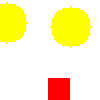

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
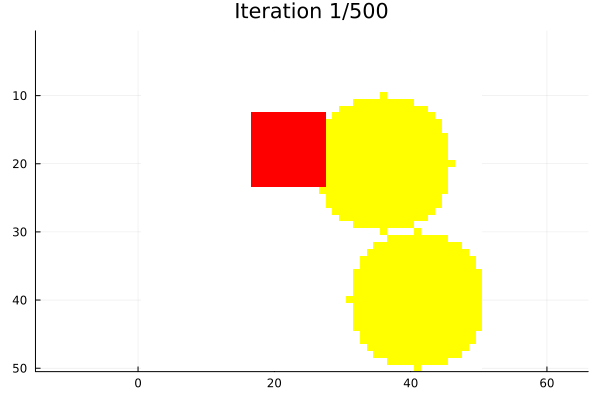

In [38]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)
num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_resimulation_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

Obs: 


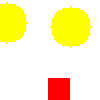

MCMC: 


[ Info: Saved animation to /Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif


Plots.AnimatedGif("/Users/zackankner/Desktop/ai/PerceptToWorldModel/ppl/tmp.gif")
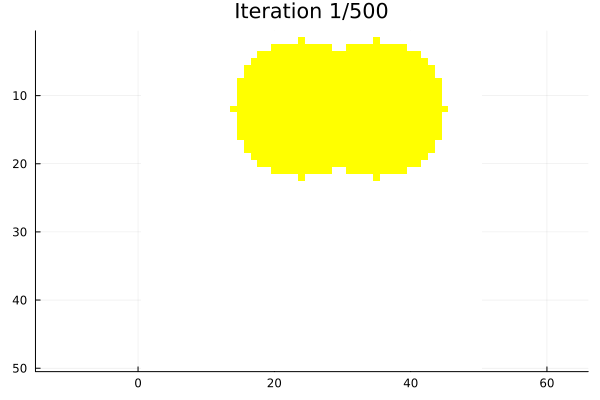

In [39]:
# MCMC visualization util
constraints = Gen.choicemap()
constraints[:obs] = obs
constraints[:latents => :n_objects] = obs_trace[:n_objects]
for i in 1:obs_trace[:n_objects]+1
    constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
    constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
end

println("Obs: ")
display(to_display_img(obs))
println("MCMC: ")
t, = generate(render_model, (), constraints)

num_iter = 500
viz = Plots.@animate for i in 1:num_iter
    global t
    t = block_drift_update(t, constraints)
    plot(to_display_img(render(t[:latents])), title="Iteration $i/$num_iter")
end;
gif(viz)

## SMC

In [391]:
function particle_filter(model, num_particles::Int, constraints, num_steps::Int, num_samples::Int)

    # Initialize particles
    state = Gen.initialize_particle_filter(model, (), constraints, num_particles)
    
    # steps
    for t=1:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        # obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (), (UnknownChange(),), Gen.choicemap())
    end
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [392]:
constraints = Gen.choicemap()
constraints[:obs] = obs

# constraints[:latents => :n_objects] = obs_trace[:n_objects]
# for i in 1:obs_trace[:n_objects]+1
#     constraints[:latents => (:shape, i)] = obs_trace[(:shape, i)]
#     constraints[:latents => (:color, i)] = obs_trace[(:color, i)]
# end

traces = particle_filter(render_model, 100, constraints, 1000, 10);

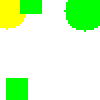

In [393]:
to_display_img(obs)

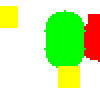

In [403]:
to_display_img(render(traces[9][:latents]))

In [407]:
get_score(traces[1])

-31.47789251385021

In [408]:
exp(obs_score(obs, render(traces[1][:latents])))

0.2661691542288556

# Paper results methods

## Storing fixed observations

In [739]:
NUM_OBSERVATIONS = 3;

#### We first build observations whose shapes don't overlap

In [740]:
@gen function render_no_overlaps()
    overlap = true
    x = nothing
    while overlap
        latents ~ scene()
        x, overlap = render(latents, false, true)
    end
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_no_overlaps#3944", Bool[], false)

Observation 1


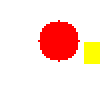

Observation 2


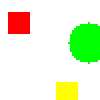

Observation 3


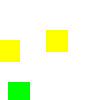

In [745]:
# # Commented out because only want to run once

# for obs_idx in 1:NUM_OBSERVATIONS
#     println("Observation $obs_idx")
#     obs = render_no_overlaps()
#     open("observations/no-overlap/obs-$obs_idx.bin", "w") do file
#         serialize(file, obs)
#     end
#     display(to_display_img(obs))
# end

#### We next build observations with overlaps to induce structural uncertainty

In [746]:
@gen function render_with_overlaps()
    overlap = false
    x = nothing
    while !overlap
        latents ~ scene()
        x, overlap = render(latents, false, true)
    end
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##render_with_overlaps#3945", Bool[], false)

Observation 1


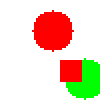

Observation 2


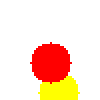

Observation 3


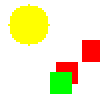

In [831]:
# # Commented out because only want to run once

# for obs_idx in 1:NUM_OBSERVATIONS
#     println("Observation $obs_idx")
#     obs = render_with_overlaps()
#     open("observations/with-overlap/obs-$obs_idx.bin", "w") do file
#         serialize(file, obs)
#     end
#     display(to_display_img(obs))
# end

#### Utility to load saved observations

In [832]:
function load_observations(base_path)
    observations = []
    for obs_idx in 1:NUM_OBSERVATIONS
        open("$base_path/obs-$obs_idx.bin", "r") do file
            push!(observations, deserialize(file))
        end
    end
    return observations
end

load_observations (generic function with 1 method)

In [835]:
no_overlap_observations = load_observations("observations/no-overlap");
with_overlap_observations = load_observations("observations/with-overlap");

## Prompts

#### Prompt for VLM

List all objects in the image. For each object state the color and shape of the object. The possible shapes are "square" and "circle". The possible colors are "green", "red", and "yellow". Return nothing else but this list. Do not miss a single object even if they are overlapping. Try to list objects that are in the background, ie have something on top of them, earlier.


#### Prompt for code model

Convert descriptions of a scene into constraints. Make sure to respect the syntax shown in the example:

Description:

Yellow circle
Yellow circle
Green square
Green square


Constraints:

constraints[:latents => :n_objects] = 4

constraints[:latents => (:color, 1)] = yellow
constraints[:latents => (:shape, 1)] = circle

constraints[:latents => (:color, 2)] = yellow
constraints[:latents => (:shape, 2)] = circle

constraints[:latents => (:color, 3)] = green
constraints[:latents => (:shape, 3)] = square

constraints[:latents => (:color, 1)] = green
constraints[:latents => (:shape, 1)] = square



Description: [FILL DESCRIPTION HERE]

Constraints:

In [936]:
# Example results: https://chat.openai.com/share/faf4c064-3cc3-4f50-8725-52c0d0d0b20d

#### Results from prompting below

#### No overlap
Obs 1

VLM:

Red circle
Yellow square

Code Model:

constraints[:latents => :n_objects] = 2

constraints[:latents => (:color, 1)] = "red"
constraints[:latents => (:shape, 1)] = "circle"

constraints[:latents => (:color, 2)] = "yellow"
constraints[:latents => (:shape, 2)] = "square"


Obs 2

VLM:

Red square
Green circle
Yellow square

Code Model:

constraints[:latents => :n_objects] = 3

constraints[:latents => (:color, 1)] = "red"
constraints[:latents => (:shape, 1)] = "square"

constraints[:latents => (:color, 2)] = "green"
constraints[:latents => (:shape, 2)] = "circle"

constraints[:latents => (:color, 3)] = "yellow"
constraints[:latents => (:shape, 3)] = "square"

Obs 3

VLM:

Green square
Yellow square
Yellow square

Code Model:

constraints[:latents => :n_objects] = 3

constraints[:latents => (:color, 1)] = "green"
constraints[:latents => (:shape, 1)] = "square"

constraints[:latents => (:color, 2)] = "yellow"
constraints[:latents => (:shape, 2)] = "square"

constraints[:latents => (:color, 3)] = "yellow"
constraints[:latents => (:shape, 3)] = "square"

#### With overlap
Obs 1

VLM:

Red circle
Red square
Green circle

Code Model:

constraints[:latents => :n_objects] = 3

constraints[:latents => (:color, 1)] = "red"
constraints[:latents => (:shape, 1)] = "circle"

constraints[:latents => (:color, 2)] = "red"
constraints[:latents => (:shape, 2)] = "square"

constraints[:latents => (:color, 3)] = "green"
constraints[:latents => (:shape, 3)] = "circle"


Obs 2

VLM:

Yellow square
Red circle

Code Model:

constraints[:latents => :n_objects] = 2

constraints[:latents => (:color, 1)] = "yellow"
constraints[:latents => (:shape, 1)] = "square"

constraints[:latents => (:color, 2)] = "red"
constraints[:latents => (:shape, 2)] = "circle"


Obs 3

VLM:

Yellow circle
Red square
Green square
Red square

Code Model:

constraints[:latents => :n_objects] = 4

constraints[:latents => (:color, 1)] = "yellow"
constraints[:latents => (:shape, 1)] = "circle"

constraints[:latents => (:color, 2)] = "red"
constraints[:latents => (:shape, 2)] = "square"

constraints[:latents => (:color, 3)] = "green"
constraints[:latents => (:shape, 3)] = "square"

constraints[:latents => (:color, 4)] = "red"
constraints[:latents => (:shape, 4)] = "square"

In [987]:
prompt_shape_map = Dict("square" => 1, "circle" => 2);
prompt_color_map = Dict("red" => 1, "yellow" => 2, "green" => 3);

In [1031]:
# No overlap

# obs 1
no_overlap_obs_1_constraints = Gen.choicemap()
no_overlap_obs_1_constraints[:latents => :n_objects] = 1

no_overlap_obs_1_constraints[:latents => (:color, 1)] = prompt_color_map["red"]
no_overlap_obs_1_constraints[:latents => (:shape, 1)] = prompt_shape_map["circle"]

no_overlap_obs_1_constraints[:latents => (:color, 2)] = prompt_color_map["yellow"]
no_overlap_obs_1_constraints[:latents => (:shape, 2)] = prompt_shape_map["square"]

# obs 2
no_overlap_obs_2_constraints = Gen.choicemap()
no_overlap_obs_2_constraints[:latents => :n_objects] = 2

no_overlap_obs_2_constraints[:latents => (:color, 1)] = prompt_color_map["red"]
no_overlap_obs_2_constraints[:latents => (:shape, 1)] = prompt_shape_map["square"]

no_overlap_obs_2_constraints[:latents => (:color, 2)] = prompt_color_map["green"]
no_overlap_obs_2_constraints[:latents => (:shape, 2)] = prompt_shape_map["circle"]

no_overlap_obs_2_constraints[:latents => (:color, 3)] = prompt_color_map["yellow"]
no_overlap_obs_2_constraints[:latents => (:shape, 3)] = prompt_shape_map["square"]

# obs 3
no_overlap_obs_3_constraints = Gen.choicemap()
no_overlap_obs_3_constraints[:latents => :n_objects] = 2

no_overlap_obs_3_constraints[:latents => (:color, 1)] = prompt_color_map["green"]
no_overlap_obs_3_constraints[:latents => (:shape, 1)] = prompt_shape_map["square"]

no_overlap_obs_3_constraints[:latents => (:color, 2)] = prompt_color_map["yellow"]
no_overlap_obs_3_constraints[:latents => (:shape, 2)] = prompt_shape_map["square"]

no_overlap_obs_3_constraints[:latents => (:color, 3)] = prompt_color_map["yellow"]
no_overlap_obs_3_constraints[:latents => (:shape, 3)] = prompt_shape_map["square"]

all_no_overlap_constraints = [no_overlap_obs_1_constraints, no_overlap_obs_2_constraints, no_overlap_obs_3_constraints];

In [1016]:
# With overlap

# obs 1
with_overlap_obs_1_constraints = Gen.choicemap()
with_overlap_obs_1_constraints[:latents => :n_objects] = 2

with_overlap_obs_1_constraints[:latents => (:color, 1)] = prompt_color_map["red"]
with_overlap_obs_1_constraints[:latents => (:shape, 1)] = prompt_shape_map["circle"]

with_overlap_obs_1_constraints[:latents => (:color, 2)] = prompt_color_map["red"]
with_overlap_obs_1_constraints[:latents => (:shape, 2)] = prompt_shape_map["square"]

with_overlap_obs_1_constraints[:latents => (:color, 3)] = prompt_color_map["green"]
with_overlap_obs_1_constraints[:latents => (:shape, 3)] = prompt_shape_map["circle"]

# obs 2
with_overlap_obs_2_constraints = Gen.choicemap()
with_overlap_obs_2_constraints[:latents => :n_objects] = 1

with_overlap_obs_2_constraints[:latents => (:color, 1)] = prompt_color_map["yellow"]
with_overlap_obs_2_constraints[:latents => (:shape, 1)] = prompt_shape_map["square"]

with_overlap_obs_2_constraints[:latents => (:color, 2)] = prompt_color_map["red"]
with_overlap_obs_2_constraints[:latents => (:shape, 2)] = prompt_shape_map["circle"]

# obs 3
with_overlap_obs_3_constraints = Gen.choicemap()
with_overlap_obs_3_constraints[:latents => :n_objects] = 3

with_overlap_obs_3_constraints[:latents => (:color, 1)] = prompt_color_map["yellow"]
with_overlap_obs_3_constraints[:latents => (:shape, 1)] = prompt_shape_map["circle"]

with_overlap_obs_3_constraints[:latents => (:color, 2)] = prompt_color_map["red"]
with_overlap_obs_3_constraints[:latents => (:shape, 2)] = prompt_shape_map["square"]

with_overlap_obs_3_constraints[:latents => (:color, 3)] = prompt_color_map["green"]
with_overlap_obs_3_constraints[:latents => (:shape, 3)] = prompt_shape_map["square"]

with_overlap_obs_3_constraints[:latents => (:color, 4)] = prompt_color_map["red"]
with_overlap_obs_3_constraints[:latents => (:shape, 4)] = prompt_shape_map["square"]

all_with_overlap_constraints = [with_overlap_obs_1_constraints, with_overlap_obs_2_constraints, with_overlap_obs_3_constraints];

## Inference procedures
We now define a common interface for all inference procedures so we can easily experiment with their performance.

Each procedure must take in:
* a max number of inference steps (samples for importance, transitions for MCMC, total particles for SMC)
* evaluate the MAP estimate at each order of magnitude in steps

### Inference helper fn

In [456]:
# Inference display utils
function render_latent_dist(traces)
    cum_sampled_scene = render(traces[1][:latents]) * (1 / length(traces))
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * (1 / length(traces))
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

render_latent_dist (generic function with 1 method)

In [462]:
foo = [1,2,3]
foo[1:3]

foo = nothing
if foo == nothing
    print("calledd")
end

calledd

In [ ]:
# Inference display utils
function get_ml_estimate(traces)
    num_powers = log10(length(traces))
    for power in 2:
    cum_sampled_scene = render(traces[1][:latents]) * (1 / length(traces))
    for i=2:length(traces)
        sampled_scene = render(traces[i][:latents]) * (1 / length(traces))
        cum_sampled_scene += sampled_scene
    end
    return cum_sampled_scene
end

### Importance Sampling

In [489]:
# Example inference procedure
function importance_sample_inference(model, constraints, max_computation)
    if !isinteger(log10(max_computation))
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end
    if max_computation < 1000
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end
    
    samples_per_iter = 100
    all_traces = []
    best_trace = nothing
    best_likelihood = 0
    
    for iter in 1:max_computation ÷ 100
        (trace, _) = Gen.importance_resampling(model, (), constraints, samples_per_iter);
        push!(all_traces, trace)
        likelihood = exp(obs_score(constraints[:obs], render(trace[:latents])))
        if likelihood > best_likelihood
            best_trace = trace
            best_likelihood = likelihood
        end
    end
    return all_traces, best_trace, best_likelihood
end;

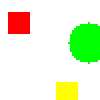

In [870]:
to_display_img(no_overlap_observations[2])

In [873]:
constraints = Gen.choicemap()
constraints[:obs] = no_overlap_observations[2]
traces_from_is, is_best_trace, is_best_likelihood = importance_sample_inference(render_model, constraints, 1000);

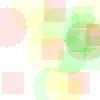

In [874]:
to_display_img(render_latent_dist(traces_from_is))

In [875]:
is_best_likelihood

0.3193979933110369

### MCMC

In [504]:
# Full resimulation
function block_resimulation_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Block to change the position
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, select(
                :latents => (:x, i),
                :latents => (:y, i),))
    end
    
    # Return the updated trace
    tr
end;

In [512]:
# Drift kernel on positions, resimulate all others

MAX_DRIFT = 10
@gen function position_proposal(current_trace, i)
    cur_x = current_trace[:latents => (:x, i)]
    cur_y = current_trace[:latents => (:y, i)]
    
    new_x_min = max(cur_x-MAX_DRIFT, 1)
    new_x_max = min(cur_x+MAX_DRIFT, IMG_SIZE)
    new_y_min = max(cur_y-MAX_DRIFT, 1)
    new_y_max = min(cur_y+MAX_DRIFT, IMG_SIZE)
    
    x = {:latents => (:x, i)} ~ uniform_discrete(new_x_min, new_x_max)
    y = {:latents => (:y, i)} ~ uniform_discrete(new_y_min, new_y_max)
end;

function block_drift_update(tr, constraints)
    # Block 1: Update the number of objects
    n_object_valid = get_unconstrained_vars((:latents => :n_objects, ), constraints)
    (tr, _) = mh(tr, select(n_object_valid...))
    
    # Block 2: Update categorical (i.e. shape & color)
    n = length(tr[:latents])
    for i=1:n
        shape_color_valid = get_unconstrained_vars(
            (
                :latents => (:shape, i),
                :latents => (:color, i),),
            constraints
        )
        (tr, _) = mh(tr, select(shape_color_valid...))
    end

    # Update block positions
    n = length(tr[:latents])
    for i=1:n
        (tr, _) = mh(tr, position_proposal, (i,))
    end
    
    # Return the updated trace
    tr
end;

In [522]:
# MCMC inference procedure
function mcmc_sample_inference(model, constraints, max_computation, mcmc_kernel)
    if !isinteger(log10(max_computation))
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end
    if max_computation < 1000
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end
    
    if mcmc_kernel == "resim"
        mcmc_fn = block_resimulation_update
    elseif mcmc_kernel == "drift"
        mcmc_fn = block_drift_update
    else
        throw(ArgumentError("Unkown mcmc kernel $mcmc_kernel"))
    end
        
    mixin = 500
    lag = 100
    all_traces = []
    best_trace = nothing
    best_likelihood = 0
    
    t, = generate(render_model, (), constraints)

    # First mixin the model
    for i = 1:mixin
        global t
        t = block_resimulation_update(t, constraints)
    end
    
    for iter in (mixin + 1):max_computation
        global t
        t = block_resimulation_update(t, constraints)

        if iter % lag == 0
            push!(all_traces, t)
            likelihood = exp(obs_score(constraints[:obs], render(t[:latents])))
            if likelihood > best_likelihood
                best_trace = t
                best_likelihood = likelihood
            end
        end
    end
    return all_traces, best_trace, best_likelihood
end;

In [876]:
constraints = Gen.choicemap()
constraints[:obs] = no_overlap_observations[2]
traces_from_mcmc, mcmc_best_trace, mcmc_best_likelihood = mcmc_sample_inference(render_model, constraints, 1000, "drift");

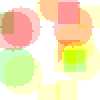

In [877]:
to_display_img(render_latent_dist(traces_from_mcmc))

In [878]:
mcmc_best_likelihood

0.14053426248548206

### SMC

In [996]:
function smc_sample_inference(model, constraints, max_computation)
    if !isinteger(log10(max_computation))
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end
    if max_computation < 1000
        throw(ArgumentError("The max iter $max_computation is not a power of 10"))
    end

    # parameters
    num_particles = 1000
    num_samples = 100
    
    samples_per_iter = 100
    best_trace = nothing
    best_likelihood = 0
    
    
    # Initialize particles
    state = Gen.initialize_particle_filter(model, (), constraints, num_particles)
    
    # steps
    for t=1:max_computation ÷ 1000
        Gen.maybe_resample!(state, ess_threshold=num_particles * 3/4)
        Gen.particle_filter_step!(state, (), (UnknownChange(),), Gen.choicemap())
    end
    
    # return a sample of unweighted traces from the weighted collection
    # println(state)
    all_traces = Gen.sample_unweighted_traces(state, num_samples)
    for trace in all_traces
        likelihood = exp(obs_score(constraints[:obs], render(trace[:latents])))
        if likelihood > best_likelihood
            best_trace = trace
            best_likelihood = likelihood
        end
    end
    
    return all_traces, best_trace, best_likelihood
end

smc_sample_inference (generic function with 1 method)

In [918]:
constraints = Gen.choicemap()
constraints[:obs] = no_overlap_observations[2]
traces_from_smc, smc_best_trace, smc_best_likelihood = smc_sample_inference(render_model, constraints, 1000);

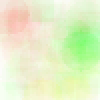

In [919]:
to_display_img(render_latent_dist(traces_from_smc))

In [920]:
smc_best_likelihood

0.45029239766081863

## Collect paper results

In [1038]:
NUM_SEED = 3
MAX_STEPS = 100000

100000

In [1039]:
function collect_results(model, constraints, seeds, max_compute_steps)
    is_results = []
    resim_mcmc_results =  []
    drift_mcmc_results = []
    smc_results = []
    for seed in 1:seeds
        log_steps = log10(max_compute_steps)
        per_seed_is_results =  []
        per_seed_resim_mcmc_results =  []
        per_seed_drift_mcmc_results = []
        per_seed_smc_results = []
        
        for power in 3:log_steps
            
            max_steps = trunc(Int, 10 ^ power)
            traces_from_is, is_best_trace, is_best_likelihood = importance_sample_inference(model, constraints, max_steps);
            is_latent_dist = render_latent_dist(traces_from_is)
            push!(per_seed_is_results, (is_latent_dist, is_best_trace, is_best_likelihood))

            traces_from_resim_mcmc, resim_mcmc_best_trace, resim_mcmc_best_likelihood = mcmc_sample_inference(model, constraints, max_steps, "resim");
            resim_mcmc_latent_dist = render_latent_dist(traces_from_resim_mcmc)
            push!(per_seed_resim_mcmc_results, (resim_mcmc_latent_dist, resim_mcmc_best_trace, resim_mcmc_best_likelihood))

            traces_from_drift_mcmc, drift_mcmc_best_trace, drift_mcmc_best_likelihood = mcmc_sample_inference(model, constraints, max_steps, "drift");
            drift_mcmc_latent_dist = render_latent_dist(traces_from_drift_mcmc)
            push!(per_seed_drift_mcmc_results, (drift_mcmc_latent_dist, drift_mcmc_best_trace, drift_mcmc_best_likelihood))

            traces_from_smc, smc_best_trace, smc_best_likelihood = smc_sample_inference(model, constraints, max_steps);
            smc_latent_dist = render_latent_dist(traces_from_smc)
            push!(per_seed_smc_results, (smc_latent_dist, smc_best_trace, smc_best_likelihood))
        end

        push!(is_results, per_seed_is_results)
        push!(resim_mcmc_results, per_seed_resim_mcmc_results)
        push!(drift_mcmc_results, per_seed_drift_mcmc_results)
        push!(smc_results, per_seed_smc_results)
    end

    return is_results, resim_mcmc_results, drift_mcmc_results, smc_results
end;

In [1040]:
function get_all_obs_results(with_overlap, with_constraints)
    if with_overlap
        all_obs = with_overlap_observations
    else
        all_obs = no_overlap_observations
    end

    all_obs_results = []
    for (obs_idx, obs) in enumerate(all_obs[1:length(all_obs)])
        println("Working on obs $obs_idx")
        if with_constraints
            if with_overlap
                obs_constraints = deepcopy(all_with_overlap_constraints[obs_idx])
            else
                obs_constraints = deepcopy(all_no_overlap_constraints[obs_idx])
            end
        else
            obs_constraints = Gen.choicemap()
        end
        obs_constraints[:obs] = obs
        display(to_display_img(obs))
        obs_results = collect_results(render_model, obs_constraints, NUM_SEED, MAX_STEPS)
        push!(all_obs_results, obs_results)
    end
    return all_obs_results
end;

Getting no overlap results
Working on obs 1


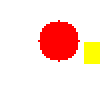

Working on obs 2


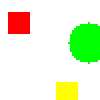

Working on obs 3


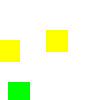

Getting overlap results
Working on obs 1


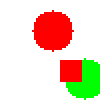

Working on obs 2


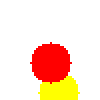

Working on obs 3


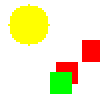

3-element Vector{Any}:
 (Any[Any[([[0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] … [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999]; [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] … [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999]; … ; [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] … [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999]; [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] … [0.9999999999999999, 0.9999999999999999, 0.9999999999999999] [0.9999999999999999, 0.999999999999

In [935]:
# Comment out so dont re-run

# println("Getting no overlap results")
# no_overlap_no_constrain_results = get_all_obs_results(false, false);

# println("Getting overlap results")
# with_overlap_no_constraint_results = get_all_obs_results(true, false);

Getting no overlap results
Working on obs 1


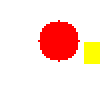

Working on obs 2


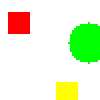

Working on obs 3


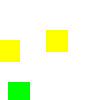

Getting overlap results
Working on obs 1


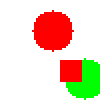

Working on obs 2


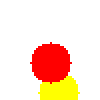

Working on obs 3


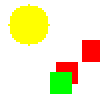

In [1041]:
println("Getting no overlap results")
no_overlap_with_constraint_results = get_all_obs_results(false, true);

println("Getting overlap results")
with_overlap_with_constraint_results = get_all_obs_results(true, true);

In [940]:
using Statistics, Plots.PlotMeasures

In [1042]:
function plot_perf_per_compute(all_results, save_name)
    
    num_seeds = length(all_results[1][1])
    step_powers = length(all_results[1][1][1])
    keys = ["Importance", "Resim MCMC", "Drift MCMC", "SMC"]

    function int_to_superscript(n)
        superscript_map = Dict('0' => "⁰", '1' => "¹", '2' => "²", '3' => "³", '4' => "⁴", '5' => "⁵", '6' => "⁶", '7' => "⁷", '8' => "⁸", '9' => "⁹")
        return join([superscript_map[digit] for digit in string(n)])
    end
    xticks = ["10$(int_to_superscript(i))" for i in 3:step_powers+3]

    total_width = 400 * length(all_results)
    total_height = 450
    
    p = plot(layout = (1, length(all_results)), size = (total_width, total_height), aspect_ratio = :auto, margin=15mm)
    for (obs_idx, result_set) in enumerate(all_results)
        for (method_idx, method) in enumerate(result_set)
            method_likelihoods = []
            method_stes = []
            for step in 1:step_powers
                likelihoods_at_step = [all_results[obs_idx][method_idx][seed_idx][step][3] for seed_idx in 1:num_seeds]
                push!(method_likelihoods, sum(likelihoods_at_step) / num_seeds)
                step_ste = std(likelihoods_at_step) / sqrt(num_seeds)
                push!(method_stes, step_ste)
            end
            key = keys[method_idx]
            plot!(p[obs_idx], 1:length(method_likelihoods), method_likelihoods, yerror=method_stes, label="$key")
        end
        plot!(p[obs_idx], title = "Observation $obs_idx", xlabel = "Total Compute Steps", ylabel = "Observation Likelihood", xticks=(1:step_powers, xticks))  # Set titles, labels, and legend
    end
    savefig(p, "likelihoods/$save_name.pdf")
    display(p)
end;

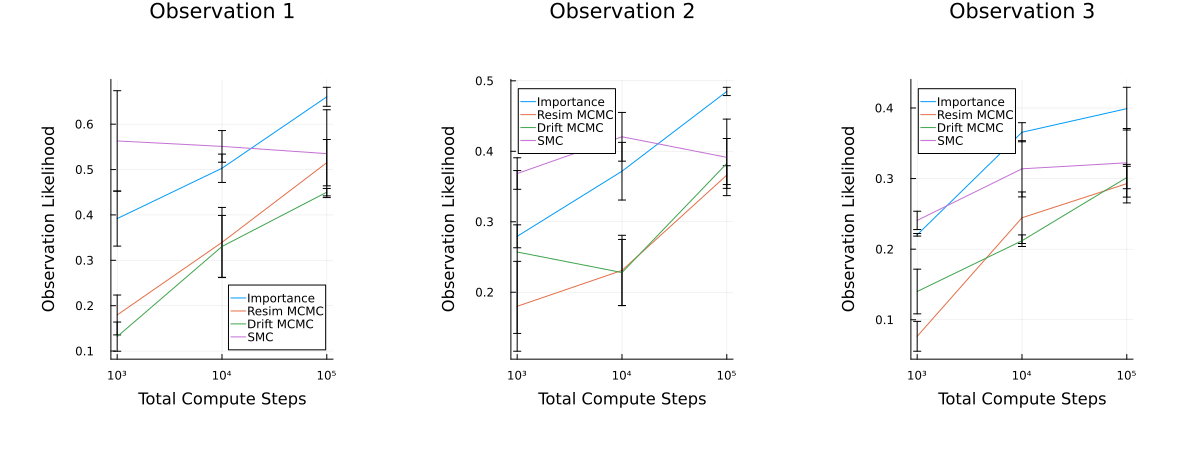

In [942]:
plot_perf_per_compute(no_overlap_no_constrain_results, "no-overlap-no-constraint")

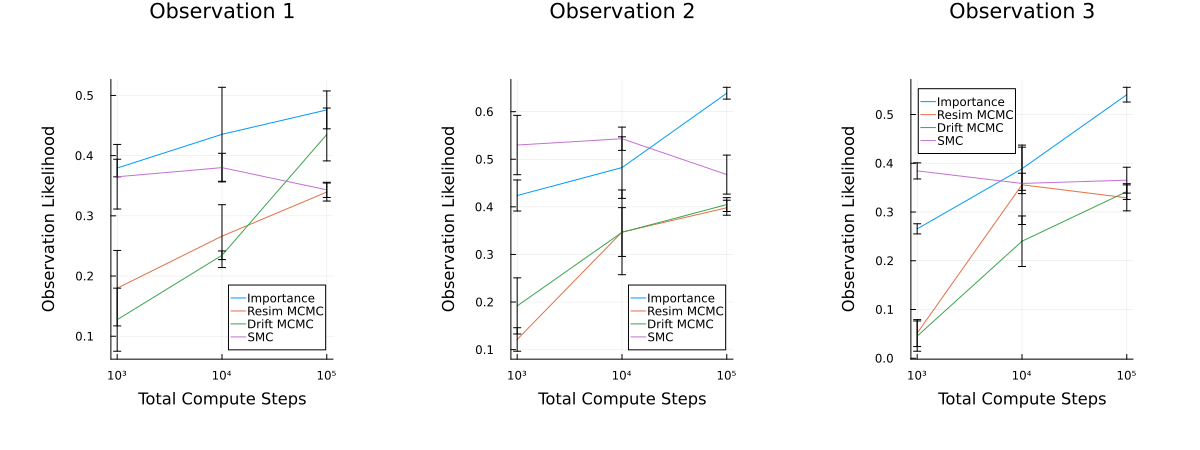

In [943]:
plot_perf_per_compute(with_overlap_no_constraint_results, "with-overlap-no-constraint")

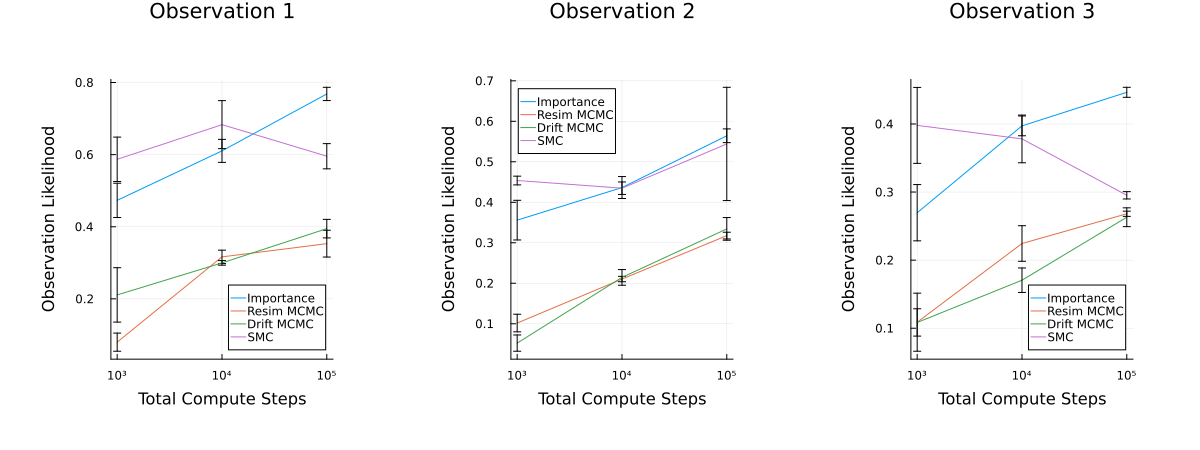

In [1043]:
plot_perf_per_compute(no_overlap_with_constraint_results, "no-overlap-with-constraint")

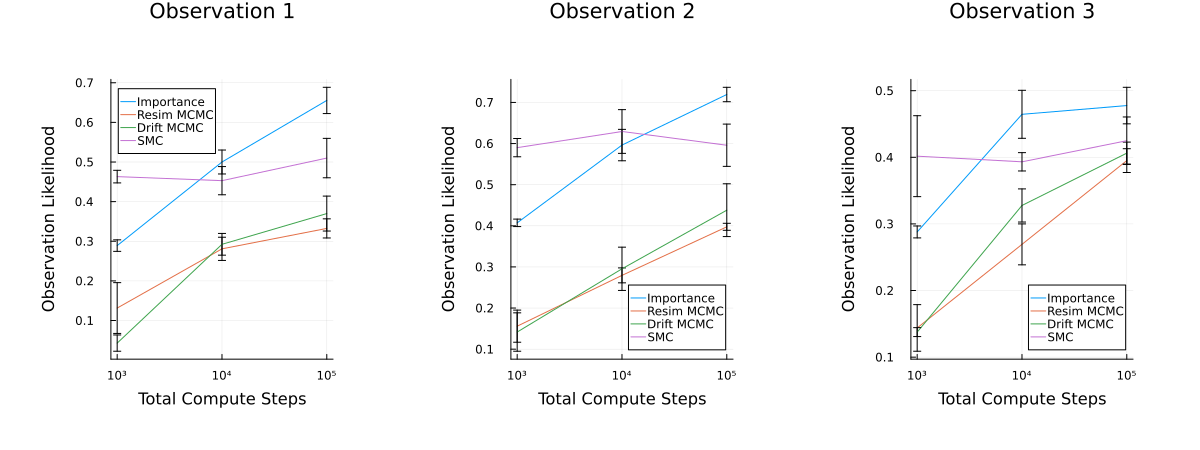

In [1044]:
plot_perf_per_compute(with_overlap_with_constraint_results, "with-overlap-with-constraint")

In [1102]:
function plot_posterior_dist(all_results, obs_idx, save_name)
    
    num_seeds = length(all_results[1][1])
    step_powers = length(all_results[1][1][1])
    keys = ["Importance", "Resim MCMC", "Drift MCMC", "SMC"]

    # total_width = 400 * length(all_results)
    # total_height = 450
    
    # p = plot(layout = (1, 5), size = (total_width, total_height), aspect_ratio = :auto, margin=15mm)
    p = plot(layout = (1, 5), margin =2Plots.mm)
    plot!(p[1], to_display_img(with_overlap_observations[obs_idx]), axis=false, ticks=false)
    # plot!(p[1], title = "True Observation")
    
    for method_idx in 1:4
        # always plotting first observation for final sample set on first seed
        method_posterior_img = to_display_img(all_results[obs_idx][method_idx][1][step_powers][1])
        plot!(p[method_idx + 1], method_posterior_img, axis=false, ticks=false, title_rotate=45)
        # plot!(p[method_idx + 1], title = "$keys[method_idx]")
    end
    savefig(p, "posterior-samples/$save_name.pdf")
    display(p)
end;

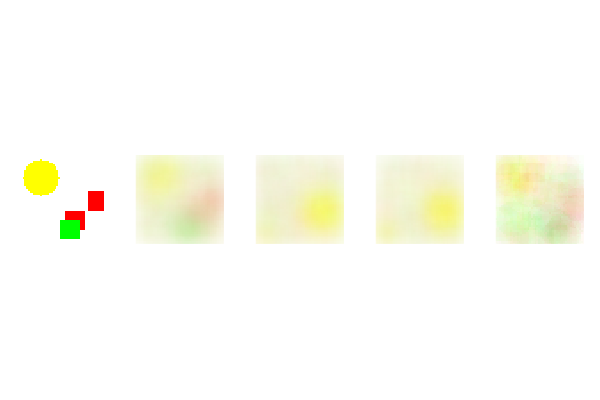

In [1104]:
plot_posterior_dist(with_overlap_no_constraint_results, 3, "with_overlap_no_constraint")

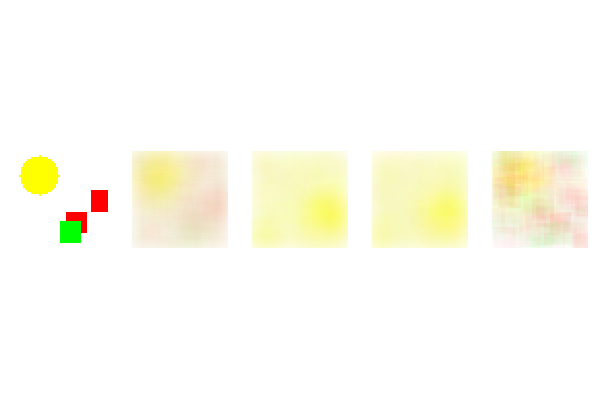

In [1095]:
plot_posterior_dist(with_overlap_with_constraint_results, 3, "foo")

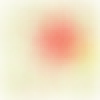

In [1068]:
# Useful indexing to remember for getting images
to_display_img(no_overlap_no_constrain_results[1][1][1][3][1])